In [ ]:
project_id = "dm-project-458907"           # ← replace this
dataset_id = "CurrentEmploymentStatistics"           # BigQuery dataset (will be created)
table_id   = "ces"           # Table name
destination = f"{dataset_id}.{table_id}"

In [ ]:
import os
import pandas as pd
import numpy as np
from pandas_gbq import read_gbq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import dash
from dash import dcc, html, Input, Output
import plotly.express as px

In [ ]:
asset_dir = 'assets'
# Ensure assets directory exists for Dash to serve static images
os.makedirs(asset_dir, exist_ok=True)


In [4]:
# 4. Data Acquisition & Processing
# ------------------------------------------------------
query = f"SELECT * FROM `{project_id}.{dataset_id}.{table_id}`"
df = read_gbq(query, project_id=project_id)

df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna(subset=['Current Employment'])
df['Seasonally Adjusted'] = df['Seasonally Adjusted'].astype(int)
df['MonthNum'] = df['Date'].dt.month

Downloading: 100%|██████████|


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536134 entries, 0 to 536133
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   _id                  536134 non-null  Int64         
 1   Area Type            536134 non-null  object        
 2   Area Name            536134 non-null  object        
 3   Year                 536134 non-null  Int64         
 4   Month                536134 non-null  object        
 5   Date                 536134 non-null  datetime64[ns]
 6   Series Code          536134 non-null  Int64         
 7   Industry Title       536134 non-null  object        
 8   Seasonally Adjusted  536134 non-null  int64         
 9   Current Employment   536134 non-null  Int64         
 10  Benchmark            536134 non-null  Int64         
 11  MonthNum             536134 non-null  int32         
dtypes: Int64(5), datetime64[ns](1), int32(1), int64(1), object(4)
memory usa

In [6]:
# 1. See where nulls remain
print(df.isnull().sum())

_id                    0
Area Type              0
Area Name              0
Year                   0
Month                  0
Date                   0
Series Code            0
Industry Title         0
Seasonally Adjusted    0
Current Employment     0
Benchmark              0
MonthNum               0
dtype: int64


In [7]:
df.drop_duplicates(inplace=True)

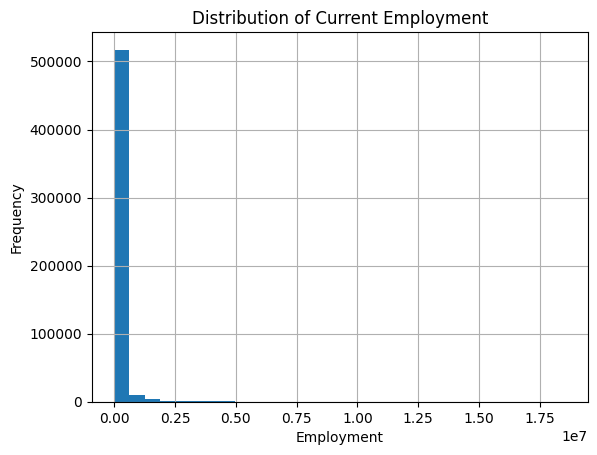

In [19]:
# 5. Exploratory Data Analysis & Vector-Format Visualization
# ------------------------------------------------------
# Save vector plots to assets folder
# 5.1 Distribution of Current Employment
plt.figure()
df['Current Employment'].hist(bins=30)
plt.title('Distribution of Current Employment')
plt.xlabel('Employment')
plt.ylabel('Frequency')
plt.savefig(os.path.join(asset_dir,'fig1_employment_distribution.svg'), bbox_inches='tight', format='svg')
plt.show()



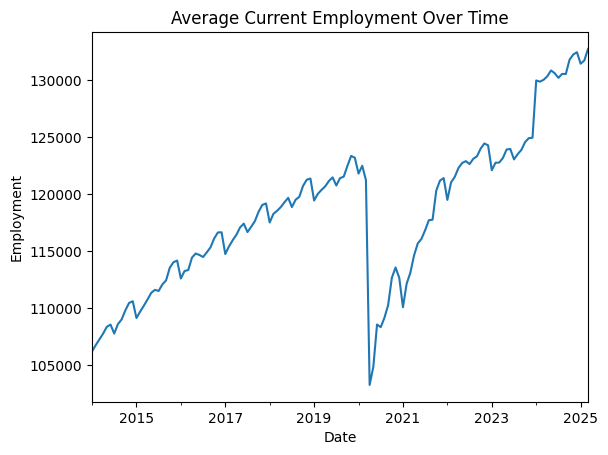

In [20]:
# 5.2 Time Series of Average Employment
plt.figure()
monthly = df.groupby('Date')['Current Employment'].mean()
monthly.plot()
plt.title('Average Current Employment Over Time')
plt.xlabel('Date')
plt.ylabel('Employment')
plt.savefig(os.path.join(asset_dir,'fig2_avg_employment_timeseries.svg'), bbox_inches='tight', format='svg')
plt.show()


In [10]:
# Top 10 industries by mean employment
industry_stats = (
    df.groupby('Industry Title')['Current Employment']
      .agg(['mean','median','std','min','max','count'])
      .sort_values('mean', ascending=False)
)
print(industry_stats.head(10))


                                                             mean    median  \
Industry Title                                                                
Total Nonfarm                                       675115.029385  129100.0   
Service-Providing                                   666918.499914  100000.0   
Total, All Industries                                589176.09314  114500.0   
Total Private                                       510402.215004   80900.0   
Private Service Providing                           446206.267613   71200.0   
Individual and Family Services                      395506.666667  254500.0   
General Medical & Surgical Hosp.s                   372105.925926  372300.0   
        Health Care and Social Assistance           228881.444276   62450.0   
Outpatient Care Centers                             221333.333333  223900.0   
              Limited-Service Restaurants and O...  162353.888889   72800.0   

                                                   

<Figure size 800x500 with 0 Axes>

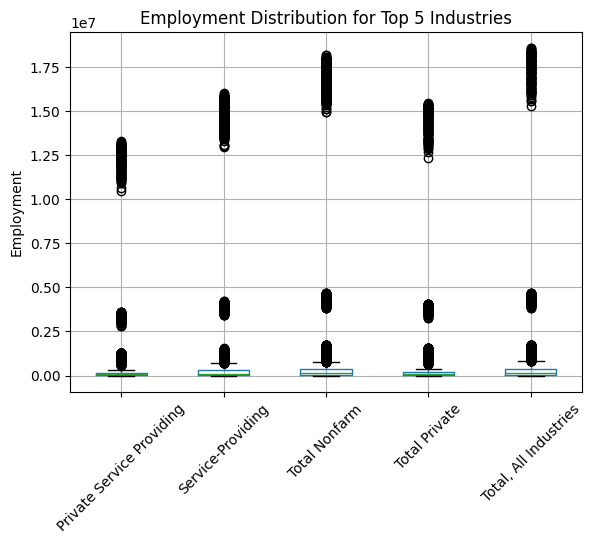

In [18]:

# Pick a handful of high-traffic industries
top_inds = industry_stats.index[:5]
plt.figure(figsize=(8,5))
df[df['Industry Title'].isin(top_inds)] \
  .boxplot(column='Current Employment', by='Industry Title', rot=45)
plt.title('Employment Distribution for Top 5 Industries')
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Employment')
plt.savefig(os.path.join(asset_dir,'fig2_top_5_industries.svg'), bbox_inches='tight', format='svg')
plt.show()


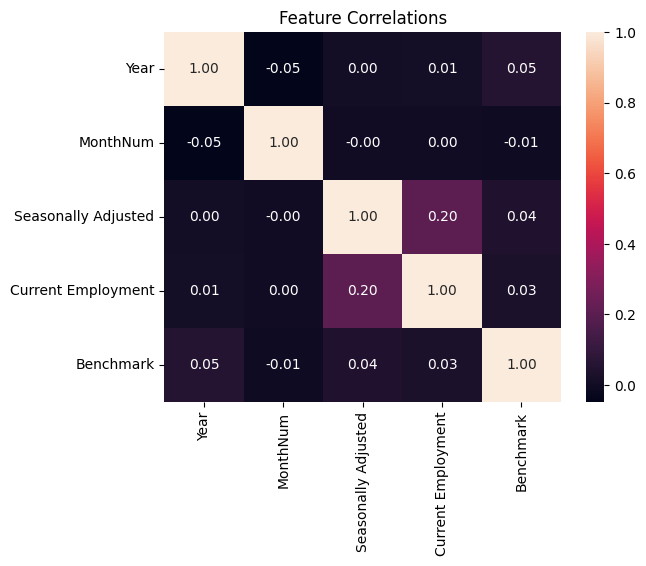

In [21]:
import seaborn as sns

corr = df[['Year','MonthNum','Seasonally Adjusted','Current Employment','Benchmark']].corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title('Feature Correlations')
plt.savefig(os.path.join(asset_dir,'fig_feature_correlations.svg'), bbox_inches='tight', format='svg')
plt.show()


In [14]:
!pip install statsmodels


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


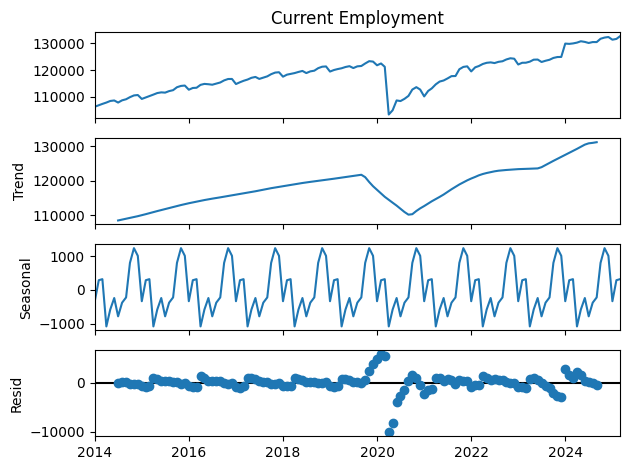

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts = df.groupby('Date')['Current Employment'].mean()
decomp = seasonal_decompose(ts, model='additive', period=12)
decomp.plot()
plt.savefig(os.path.join(asset_dir,'fig_seasonal_decompose.svg'), bbox_inches='tight', format='svg')
plt.show()


In [16]:
q1 = df['Current Employment'].quantile(0.01)
q99 = df['Current Employment'].quantile(0.99)
outliers = df[(df['Current Employment'] < q1) | (df['Current Employment'] > q99)]
print(f"Found {len(outliers)} extreme values outside the 1st–99th percentile.")


Found 10537 extreme values outside the 1st–99th percentile.


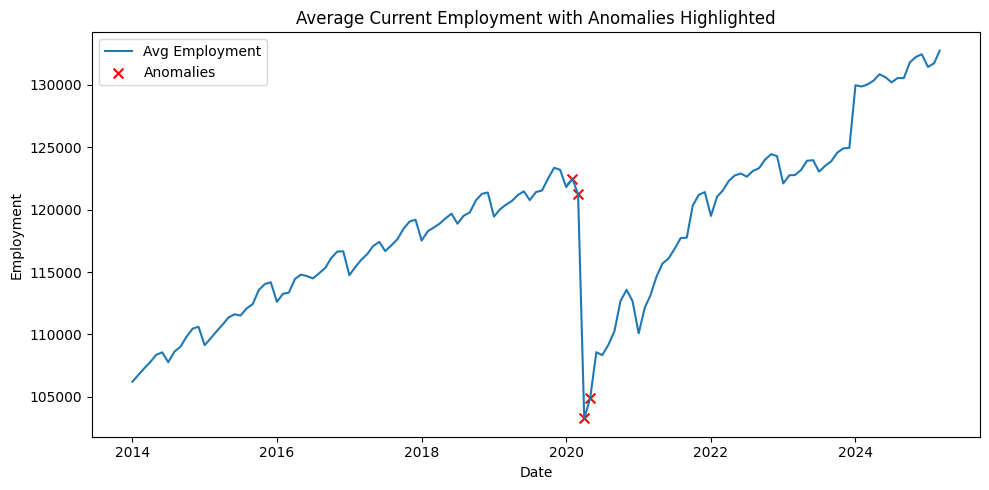

In [28]:
import matplotlib.pyplot as plt
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Compute the average series
ts = df.groupby('Date')['Current Employment'].mean()

# 2. Decompose & get residuals
decomp = seasonal_decompose(ts, model='additive', period=12)
resid = decomp.resid.dropna()

# 3. Compute Z-scores on residuals and flag anomalies
z = zscore(resid)
anomaly_mask = (z > 3) | (z < -3)
anomaly_dates = resid.index[anomaly_mask]
anomaly_values = ts.loc[anomaly_dates]

# 4. Plot series + anomalies
plt.figure(figsize=(10,5))

# Plot the main series
plt.plot(ts.index, ts.values, label='Avg Employment')

# Overlay anomalies in red
plt.scatter(anomaly_dates, anomaly_values,
            color='red', s=50, marker='x', label='Anomalies')

plt.title('Average Current Employment with Anomalies Highlighted')
plt.xlabel('Date')
plt.ylabel('Employment')
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
from sklearn.ensemble import IsolationForest

# 1. Fit on just the employment values (reshape for sklearn)
clf = IsolationForest(contamination=0.01, random_state=42)
df['anomaly_flag'] = clf.fit_predict(df[['Current Employment']])

# 2. In sklearn’s convention: –1 = anomaly, +1 = normal
anomalies_ml = df[df['anomaly_flag'] == -1]

print(f"IsolationForest found {len(anomalies_ml)} anomalies")
anomalies_ml[['Date','Industry Title','Current Employment']].head()


IsolationForest found 5207 anomalies


,Date,Industry Title,Current Employment
594,2014-01-01,"Total, All Industries",4147700
603,2014-01-01,Total Nonfarm,4169100
604,2014-01-01,Total Nonfarm,4141800
605,2014-01-01,Total Private,3588100
664,2014-01-01,Private Service Providing,3097300


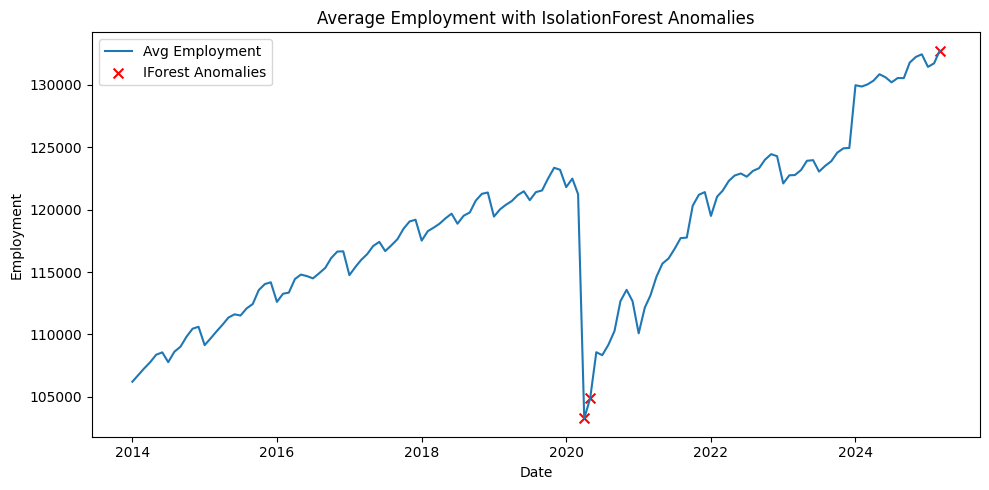

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 1. Build the series
ts = df.groupby('Date')['Current Employment'].mean()

# 2. Fit IsolationForest on the 1D series
clf = IsolationForest(contamination=0.02, random_state=42)
vals = ts.values.reshape(-1, 1)
clf.fit(vals)

# 3. Flag the anomalies
flags = clf.predict(vals)  # -1 = anomaly, +1 = normal
anom_ts = ts.iloc[flags == -1]

# 4. Plot
plt.figure(figsize=(10,5))
plt.plot(ts.index, ts.values, label='Avg Employment')
plt.scatter(anom_ts.index, anom_ts.values,
            color='red', s=50, marker='x', label='IForest Anomalies')
plt.title('Average Employment with IsolationForest Anomalies')
plt.xlabel('Date')
plt.ylabel('Employment')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(asset_dir,'fig_anomaly_detection.svg'), bbox_inches='tight', format='svg')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from jupyter_dash import JupyterDash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go

# --- 1. Prepare a wide ts DataFrame: one column per industry ---
# (You can skip this if you already have `ts` as in your notebook)
ts = df.pivot_table(
    index='Date',
    columns='Industry Title',
    values='Current Employment',
    aggfunc='mean'
).sort_index()

# --- 2. Helper to detect anomalies on a single series ---
def detect_anomalies(series, contamination=0.02):
    vals = series.values.reshape(-1,1)
    clf = IsolationForest(contamination=contamination, random_state=42)
    flags = clf.fit_predict(vals)   # -1 anomaly, +1 normal
    return series.iloc[flags == -1]

# --- 3. Build the Dash app ---
app = JupyterDash(__name__)

# Dropdown options
industries = ts.columns.tolist()

app.layout = html.Div([
    html.H2("Industry-Level Anomaly Detection"),
    dcc.Dropdown(
        id='industry-dropdown',
        options=[{'label': i, 'value': i} for i in industries],
        value=industries[0],
        clearable=False,
        style={'width':'600px'}
    ),
    dcc.Graph(id='anomaly-graph')
])

# --- 4. Callback to update the anomaly plot ---
@app.callback(
    Output('anomaly-graph', 'figure'),
    Input('industry-dropdown', 'value')
)
def update_anomaly_graph(selected_industry):
    # extract the series for that industry
    series = ts[selected_industry].dropna()
    # detect anomalies
    anoms = detect_anomalies(series)
    
    # build Plotly figure
    fig = go.Figure([
        go.Scatter(
            x=series.index, y=series.values,
            mode='lines', name='Historical'
        ),
        go.Scatter(
            x=anoms.index, y=anoms.values,
            mode='markers', name='Anomaly',
            marker=dict(color='red', size=8, symbol='x')
        )
    ])
    fig.update_layout(
        title=f"Anomalies in {selected_industry}",
        xaxis_title="Date",
        yaxis_title="Current Employment",
        template="simple_white"
    )
    return fig

# --- 5. Run inline in a notebook ---
app.run(mode='inline', port=8051)



c:\Users\veena\AppData\Local\Programs\Python\Python312\Lib\site-packages\dash\dash.py:587: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.

